In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl

import requests

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font",family=font_name)
pd.set_option('display.max_rows', None)
mpl.rcParams["axes.unicode_minus"]= False

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm, metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
train1= pd.read_csv("data/201901-202003.csv")
train2= pd.read_csv('data/202004.csv')

submission = pd.read_csv('data/submission.csv')

train = train1.append(train2,ignore_index=True)
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


### 결측치 채우기

In [4]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

data = train.copy()
data = data.fillna('세종시')

data['YEAR'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['MONTH'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
# data = data.drop(['REG_YYMM'], axis=1)

In [5]:
# data["REG_YYMM"] = pd.to_datetime(data["REG_YYMM"],format='%Y%m')
# data.head()

### AGE값 변경

In [6]:
data['AGE'] = data['AGE'].str.rstrip('s').astype('int')
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,YEAR,MONTH
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20,1,1,4,311200,4,2019,1
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,1,2,7,1374500,8,2019,1
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,2,2,6,818700,6,2019,1
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,3,4,1717000,5,2019,1
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,4,3,1047300,3,2019,1


- 201901에서 202004까지 16개 월을 1에서 16으로 대체

In [8]:
data['REG_YYMM_1'] = data['REG_YYMM']
for i, j in enumerate(data['REG_YYMM'].unique()):
    data.REG_YYMM_1 = data.REG_YYMM_1.replace(j, i+1)
data.REG_YYMM_1 = data.REG_YYMM_1.astype(int)

submission['REG_YYMM_1'] = submission['REG_YYMM']
submission.REG_YYMM_1 = submission.REG_YYMM_1.replace(submission.REG_YYMM_1.value_counts().sort_index().index[0],16)
submission.REG_YYMM_1 = submission.REG_YYMM_1.replace(submission.REG_YYMM_1.value_counts().sort_index().index[1],19)

In [9]:
data['REG_YYMM_1'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [10]:
submission['REG_YYMM_1'].unique()

array([16, 19], dtype=int64)

In [11]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,YEAR,MONTH,REG_YYMM_1
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20,1,1,4,311200,4,2019,1,1
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,1,2,7,1374500,8,2019,1,1
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,2,2,6,818700,6,2019,1,1
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,3,4,1717000,5,2019,1,1
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,4,3,1047300,3,2019,1,1


- 카드 이용 지역을 각 지역의 이름 순으로 1부터 17까지 변경

In [12]:
data['CARD_SIDO_NM'].unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

In [13]:
data['CARD_SIDO_NM_1'] = data['CARD_SIDO_NM']
for i, j in enumerate(data['CARD_SIDO_NM'].unique()):
    data.CARD_SIDO_NM_1 = data.CARD_SIDO_NM_1.replace(j, i+1)
    
    
submission['CARD_SIDO_NM_1'] = submission['CARD_SIDO_NM']
for i, j in enumerate(submission['CARD_SIDO_NM'].unique()):
    submission.CARD_SIDO_NM_1 = submission.CARD_SIDO_NM_1.replace(j, i+1)

In [14]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,YEAR,MONTH,REG_YYMM_1,CARD_SIDO_NM_1
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20,1,1,4,311200,4,2019,1,1,1
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,1,2,7,1374500,8,2019,1,1,1
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30,2,2,6,818700,6,2019,1,1,1
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,3,4,1717000,5,2019,1,1,1
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40,1,4,3,1047300,3,2019,1,1,1


- 업종명도 업종명의 이름순으로 번호를 붙여 대체

In [15]:
data['STD_CLSS_NM'].unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
       '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
       '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
       '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
       '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
       '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
       '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object)

In [16]:
data['STD_CLSS_NM_1'] = data['STD_CLSS_NM']
for i in range(len(data.STD_CLSS_NM.value_counts().sort_index().index)) :
    data.STD_CLSS_NM_1 = data.STD_CLSS_NM_1.replace(data.STD_CLSS_NM.value_counts().sort_index().index[i],i+1)
    
submission['STD_CLSS_NM_1'] = submission['STD_CLSS_NM']
for i in range(len(submission.STD_CLSS_NM.value_counts().sort_index().index)) :
    submission.STD_CLSS_NM_1 = submission.STD_CLSS_NM_1.replace(submission.STD_CLSS_NM.value_counts().sort_index().index[i],i+1)

In [17]:
X = pd.DataFrame(data['AMT'].groupby([data['REG_YYMM_1'],data['CARD_SIDO_NM_1'],data['STD_CLSS_NM_1']]).sum())
X = X.reset_index()

In [18]:
df2_stats = X.describe()
df2_stats = df2_stats.transpose()
df2_stats

,count,mean,std,min,25%,50%,75%,max
REG_YYMM_1,10048.00,8.46,4.59,1.00,4.00,8.00,12.00,16.00
CARD_SIDO_NM_1,10048.00,9.00,4.95,1.00,5.00,9.00,13.00,17.00
STD_CLSS_NM_1,10048.00,21.05,11.77,1.00,11.00,21.00,31.00,41.00
AMT,10048.00,6353360511.45,18853885418.04,16500.00,152580729.25,1143854680.50,3563477851.25,248787393561.00


In [19]:
def normalization( x ):
    return ( x - df2_stats[ 'mean' ] ) / df2_stats[ 'std' ]

In [20]:
df2 = X.copy()
df3 = normalization(df2)
df2['AMT'] = df3['AMT']
df2

,REG_YYMM_1,CARD_SIDO_NM_1,STD_CLSS_NM_1,AMT
0,1,1,1,-0.33
1,1,1,2,-0.27
2,1,1,3,-0.27
3,1,1,4,-0.34
4,1,1,6,-0.34
5,1,1,7,-0.31
6,1,1,8,0.11
7,1,1,9,-0.34
8,1,1,10,-0.28
9,1,1,11,-0.32


In [21]:
# train, test 데이터로 나누기
train_df2 = df2.sample( frac = 0.8, random_state = 0 )
test_df2 = df2.drop( train_df2.index )

In [22]:
# y데이터 분리
y_train = train_df2.pop( 'AMT' )
y_test = test_df2.pop( 'AMT' )

In [23]:
# X,y 데이터를 NumPy 배열로 변경
X_train = np.asarray( train_df2)
X_test = np.asarray( test_df2)

In [24]:
X_train = np.array( train_df2)
X_test = np.array( test_df2)

y_train = np.array( y_train )
y_test = np.array( y_test )

In [56]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred): 
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
def root_mean_squared_logarithmic_error(y_true, y_pred): 
    y_pred_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.) 
    y_true_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.) 
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

In [57]:
# model = Sequential()
# model.add( Dense( 1, input_dim = 3, activation = 'relu' ) )
# model.compile(optimizer = "rmsprop", loss = root_mean_squared_logarithmic_error, metrics = [ 'mse', 'mae' ] )
# history = model.fit( X_train, y_train, batch_size = 10, epochs = 100, validation_split = 0.2 )

Train on 6430 samples, validate on 1608 samples
Epoch 1/100
6430/6430 [==============================] - 1s 222us/sample - loss: 2.7484 - mean_squared_error: 23.3319 - mean_absolute_error: 2.7484 - val_loss: 0.6806 - val_mean_squared_error: 2.0004 - val_mean_absolute_error: 0.6806
Epoch 2/100
6430/6430 [==============================] - 1s 203us/sample - loss: 0.5121 - mean_squared_error: 1.2870 - mean_absolute_error: 0.5121 - val_loss: 0.4649 - val_mean_squared_error: 1.0977 - val_mean_absolute_error: 0.4649
Epoch 3/100
6430/6430 [==============================] - 1s 204us/sample - loss: 0.4560 - mean_squared_error: 1.1045 - mean_absolute_error: 0.4560 - val_loss: 0.4627 - val_mean_squared_error: 1.0940 - val_mean_absolute_error: 0.4627
Epoch 4/100
6430/6430 [==============================] - 1s 211us/sample - loss: 0.4549 - mean_squared_error: 1.1029 - mean_absolute_error: 0.4549 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 5/100
6430/64

Epoch 36/100
6430/6430 [==============================] - 1s 214us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 37/100
6430/6430 [==============================] - 1s 226us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 38/100
6430/6430 [==============================] - 1s 212us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 39/100
6430/6430 [==============================] - 1s 215us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 40/100
6430/6430 [==============================] - 1s 215

6430/6430 [==============================] - 1s 227us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 72/100
6430/6430 [==============================] - 1s 214us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 73/100
6430/6430 [==============================] - 1s 222us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 74/100
6430/6430 [==============================] - 1s 187us/sample - loss: 0.4546 - mean_squared_error: 1.1026 - mean_absolute_error: 0.4546 - val_loss: 0.4625 - val_mean_squared_error: 1.0938 - val_mean_absolute_error: 0.4625
Epoch 75/100
6430/6430 [==============================] - 1s 188us/sample - l

In [68]:
model = Sequential()
model.add( Dense( 1, input_dim = 3, activation = 'linear' ) )
sgd = optimizers.SGD( lr =0.00001 )
model.compile( optimizer = sgd ,loss = 'mse', metrics = [ 'mse', 'mae' ] )
history = model.fit( X_train, y_train, batch_size = 10, epochs = 150, validation_split = 0.2 )

Train on 6430 samples, validate on 1608 samples
Epoch 1/150
6430/6430 [==============================] - 1s 207us/sample - loss: 32.6655 - mean_squared_error: 32.6655 - mean_absolute_error: 3.9175 - val_loss: 8.1616 - val_mean_squared_error: 8.1616 - val_mean_absolute_error: 2.2726
Epoch 2/150
6430/6430 [==============================] - 1s 161us/sample - loss: 6.4454 - mean_squared_error: 6.4454 - mean_absolute_error: 1.9727 - val_loss: 4.8424 - val_mean_squared_error: 4.8424 - val_mean_absolute_error: 1.6971
Epoch 3/150
6430/6430 [==============================] - 1s 169us/sample - loss: 3.9952 - mean_squared_error: 3.9952 - mean_absolute_error: 1.4908 - val_loss: 3.0994 - val_mean_squared_error: 3.0994 - val_mean_absolute_error: 1.2947
Epoch 4/150
6430/6430 [==============================] - 1s 180us/sample - loss: 2.6773 - mean_squared_error: 2.6773 - mean_absolute_error: 1.1503 - val_loss: 2.1629 - val_mean_squared_error: 2.1629 - val_mean_absolute_error: 1.0133
Epoch 5/150
6430/6

Epoch 36/150
6430/6430 [==============================] - 1s 190us/sample - loss: 1.0600 - mean_squared_error: 1.0600 - mean_absolute_error: 0.4538 - val_loss: 1.0459 - val_mean_squared_error: 1.0459 - val_mean_absolute_error: 0.4413
Epoch 37/150
6430/6430 [==============================] - 1s 181us/sample - loss: 1.0586 - mean_squared_error: 1.0586 - mean_absolute_error: 0.4491 - val_loss: 1.0447 - val_mean_squared_error: 1.0447 - val_mean_absolute_error: 0.4636
Epoch 38/150
6430/6430 [==============================] - 1s 185us/sample - loss: 1.0597 - mean_squared_error: 1.0597 - mean_absolute_error: 0.4541 - val_loss: 1.0455 - val_mean_squared_error: 1.0455 - val_mean_absolute_error: 0.4444
Epoch 39/150
6430/6430 [==============================] - 1s 205us/sample - loss: 1.0598 - mean_squared_error: 1.0598 - mean_absolute_error: 0.4526 - val_loss: 1.0467 - val_mean_squared_error: 1.0467 - val_mean_absolute_error: 0.4372
Epoch 40/150
6430/6430 [==============================] - 1s 171

6430/6430 [==============================] - 1s 204us/sample - loss: 1.0588 - mean_squared_error: 1.0588 - mean_absolute_error: 0.4536 - val_loss: 1.0463 - val_mean_squared_error: 1.0463 - val_mean_absolute_error: 0.4388
Epoch 72/150
6430/6430 [==============================] - 1s 200us/sample - loss: 1.0594 - mean_squared_error: 1.0594 - mean_absolute_error: 0.4515 - val_loss: 1.0456 - val_mean_squared_error: 1.0456 - val_mean_absolute_error: 0.4428
Epoch 73/150
6430/6430 [==============================] - 1s 217us/sample - loss: 1.0589 - mean_squared_error: 1.0589 - mean_absolute_error: 0.4540 - val_loss: 1.0491 - val_mean_squared_error: 1.0491 - val_mean_absolute_error: 0.4284
Epoch 74/150
6430/6430 [==============================] - 1s 202us/sample - loss: 1.0597 - mean_squared_error: 1.0597 - mean_absolute_error: 0.4501 - val_loss: 1.0456 - val_mean_squared_error: 1.0456 - val_mean_absolute_error: 0.4432
Epoch 75/150
6430/6430 [==============================] - 1s 181us/sample - l

6430/6430 [==============================] - 1s 184us/sample - loss: 1.0580 - mean_squared_error: 1.0580 - mean_absolute_error: 0.4521 - val_loss: 1.0455 - val_mean_squared_error: 1.0455 - val_mean_absolute_error: 0.4450
Epoch 107/150
6430/6430 [==============================] - 1s 201us/sample - loss: 1.0588 - mean_squared_error: 1.0588 - mean_absolute_error: 0.4491 - val_loss: 1.0450 - val_mean_squared_error: 1.0450 - val_mean_absolute_error: 0.4670
Epoch 108/150
6430/6430 [==============================] - 1s 179us/sample - loss: 1.0599 - mean_squared_error: 1.0599 - mean_absolute_error: 0.4546 - val_loss: 1.0458 - val_mean_squared_error: 1.0458 - val_mean_absolute_error: 0.4420
Epoch 109/150
6430/6430 [==============================] - 1s 193us/sample - loss: 1.0595 - mean_squared_error: 1.0595 - mean_absolute_error: 0.4491 - val_loss: 1.0446 - val_mean_squared_error: 1.0446 - val_mean_absolute_error: 0.4612
Epoch 110/150
6430/6430 [==============================] - 1s 191us/sample

Epoch 141/150
6430/6430 [==============================] - 1s 173us/sample - loss: 1.0598 - mean_squared_error: 1.0598 - mean_absolute_error: 0.4526 - val_loss: 1.0459 - val_mean_squared_error: 1.0459 - val_mean_absolute_error: 0.4413
Epoch 142/150
6430/6430 [==============================] - 1s 218us/sample - loss: 1.0590 - mean_squared_error: 1.0590 - mean_absolute_error: 0.4473 - val_loss: 1.0463 - val_mean_squared_error: 1.0463 - val_mean_absolute_error: 0.4773
Epoch 143/150
6430/6430 [==============================] - 1s 194us/sample - loss: 1.0598 - mean_squared_error: 1.0598 - mean_absolute_error: 0.4547 - val_loss: 1.0447 - val_mean_squared_error: 1.0447 - val_mean_absolute_error: 0.4532
Epoch 144/150
6430/6430 [==============================] - 1s 202us/sample - loss: 1.0598 - mean_squared_error: 1.0598 - mean_absolute_error: 0.4518 - val_loss: 1.0447 - val_mean_squared_error: 1.0447 - val_mean_absolute_error: 0.4532
Epoch 145/150
6430/6430 [==============================] - 1

In [69]:
history_dict = history.history
loss = history_dict[ 'loss' ]
val_loss = history_dict[ 'val_loss' ]

epochs = range( 1, len( loss ) + 1 )

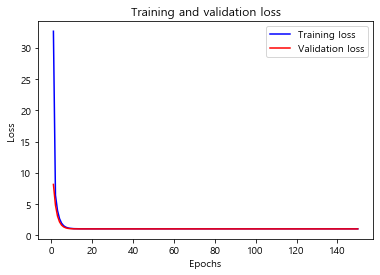

In [70]:
plt.plot( epochs, loss, 'b', label = 'Training loss' )
plt.plot( epochs, val_loss, 'r', label = 'Validation loss' )
plt.title( 'Training and validation loss' )
plt.xlabel( 'Epochs' )
plt.ylabel( 'Loss' )
plt.legend()

plt.show()

In [71]:
loss, mae, mse = model.evaluate( X_test, y_test, verbose = 2 )

print( "테스트 세트의 평균 절대 오차: {:5.2f} MPG".format( mae ) )

2010/2010 - 0s - loss: 0.5849 - mean_squared_error: 0.5849 - mean_absolute_error: 0.4107
테스트 세트의 평균 절대 오차:  0.58 MPG


In [72]:
pred = submission[['REG_YYMM_1', 'CARD_SIDO_NM_1','STD_CLSS_NM_1']]

In [73]:
pred = np.asarray(pred)
pred = np.array(pred)

In [74]:
pred

array([[16,  1,  1],
       [16,  1,  2],
       [16,  1,  3],
       ...,
       [19, 17, 39],
       [19, 17, 40],
       [19, 17, 41]], dtype=int64)

In [75]:
prd = model.predict(pred)    # Keras모델로 얻은 예측값
prd 

array([[-0.06443647],
       [-0.05039349],
       [-0.03635051],
       ...,
       [ 0.03609578],
       [ 0.05013875],
       [ 0.06418173]], dtype=float32)

In [76]:
# 예측값이 정규화 되어있으므로 정규화의 역과정을 통해 실제 예측값을 구한다.
sub1 = pd.DataFrame(prd*X['AMT'].std() + X['AMT'].mean())
sub1

,0
0,5138482688.00
1,5403247104.00
2,5668012032.00
3,5932776448.00
4,6197541376.00
5,6462305792.00
6,6727070720.00
7,6991835136.00
8,7256600064.00
9,7521364992.00


In [77]:
sbm=submission[['id','REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']] # 제출양식에 필요한 변수만 추출

In [78]:
sbm['AMT'] = sub1.loc[:,0]  # 예측값을 'AMT' 변수자리에 넣어준다.
sbm

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,5138482688.00
1,1,202004,강원,골프장 운영업,5403247104.00
2,2,202004,강원,과실 및 채소 소매업,5668012032.00
3,3,202004,강원,관광 민예품 및 선물용품 소매업,5932776448.00
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,6197541376.00
5,5,202004,강원,그외 기타 스포츠시설 운영업,6462305792.00
6,6,202004,강원,그외 기타 종합 소매업,6727070720.00
7,7,202004,강원,기타 대형 종합 소매업,6991835136.00
8,8,202004,강원,기타 수상오락 서비스업,7256600064.00
9,9,202004,강원,기타 외국식 음식점업,7521364992.00


In [55]:
sbm.to_csv('submission_final_final.csv',index =False)  # 파일로 저장